# SOM training notebook - dataset description

```read_and_transform``` takes a GEFS filename, a config dictionary, and a longitude format (default 0 - 360). This subsets your dataset based on the configuration file.

In [1]:
def read_and_transform(filename, config, long_fmt='360'):
    """`Reads in the GEFS filename and subsets the data based on the configuration 
    dictionary. This function subsets by coordinates and variable name.
    
    Parameters:
    
    filename: str
        Absolute or relative location of a GEFS file.
    config: dict
        Dictionary containing lat / lon bounds and variable name.
    long_fmt: str
        Format of longitude degrees. Default 360.
    """

    data_in = xr.open_dataset(filename)
    data_in = data_in[[config['var']]]
    
    if long_fmt == '360':
        data_in = data_in.sel(lon=slice(config['wlon'], config['elon']), 
                              lat=slice(config['nlat'], config['slat']))
    else:
        raise ValueError("-180 to 180 not implemented yet, use 0-360")
        
    data_in = data_in.squeeze()

    npy = np.array([x.flatten() for x in data_in[config['var']].values])
    
    return data_in, npy

## Here is an example of how it works.

We can find the GEFS reforecast files on triton (```/home/scratch/GEFSv12/reforecasts/conus_subset/```)

Let's read in the April 27th, 2011 forecast. The forecast has 180 time steps (which have variable temporal spacing between 3h and 6h), each grid is 71 x 171 pixels, and there are 11 ensemble members.

In [2]:
import xarray as xr

apr27 = xr.open_dataset("/home/scratch/GEFSv12/reforecasts/conus_subset/subset_vars_2011042700.nc")

apr27

/home/z2034747/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


<xarray.Dataset> Size: 3GB
Dimensions:     (time: 180, lat: 71, lon: 171, ens: 11)
Coordinates:
  * time        (time) datetime64[ns] 1kB 2011-04-27 ... 2011-05-31T18:00:00
  * lat         (lat) float32 284B 55.0 54.5 54.0 53.5 ... 21.5 21.0 20.5 20.0
  * lon         (lon) float32 684B 220.0 220.5 221.0 221.5 ... 304.0 304.5 305.0
Dimensions without coordinates: ens
Data variables: (12/26)
    u10         (ens, time, lat, lon) float32 96MB ...
    v10         (ens, time, lat, lon) float32 96MB ...
    t2m         (ens, time, lat, lon) float32 96MB ...
    td2m        (ens, time, lat, lon) float32 96MB ...
    cprec       (ens, time, lat, lon) float32 96MB ...
    prec        (ens, time, lat, lon) float32 96MB ...
    ...          ...
    sbcape_gfs  (ens, time, lat, lon) float32 96MB ...
    sbcin_gfs   (ens, time, lat, lon) float32 96MB ...
    mucape      (ens, time, lat, lon) float32 96MB ...
    mlcape      (ens, time, lat, lon) float32 96MB ...
    ulcape      (ens, time, lat, lon) float32 96MB ...
    mlcape3km   (ens, time, lat, lon) float32 96MB ...
Attributes:
    title:         Customized GEFSv12 Reforecasts
    grid:          0.5 degree CONUS subset
    author:        Dr. Victor Gensini
    author_email:  vgensini@niu.edu

To pick out one grid to display, we need to select a time and an ensemble member. Once we do this, we can see that the result is a 2D image (71 in y, 171 in x)

In [3]:
apr27_example = apr27.sel(time='2011-04-28 00:00:00', ens=1)

apr27_example

<xarray.Dataset> Size: 1MB
Dimensions:     (lat: 71, lon: 171)
Coordinates:
    time        datetime64[ns] 8B 2011-04-28
  * lat         (lat) float32 284B 55.0 54.5 54.0 53.5 ... 21.5 21.0 20.5 20.0
  * lon         (lon) float32 684B 220.0 220.5 221.0 221.5 ... 304.0 304.5 305.0
Data variables: (12/26)
    u10         (lat, lon) float32 49kB ...
    v10         (lat, lon) float32 49kB ...
    t2m         (lat, lon) float32 49kB ...
    td2m        (lat, lon) float32 49kB ...
    cprec       (lat, lon) float32 49kB ...
    prec        (lat, lon) float32 49kB ...
    ...          ...
    sbcape_gfs  (lat, lon) float32 49kB ...
    sbcin_gfs   (lat, lon) float32 49kB ...
    mucape      (lat, lon) float32 49kB ...
    mlcape      (lat, lon) float32 49kB ...
    ulcape      (lat, lon) float32 49kB ...
    mlcape3km   (lat, lon) float32 49kB ...
Attributes:
    title:         Customized GEFSv12 Reforecasts
    grid:          0.5 degree CONUS subset
    author:        Dr. Victor Gensini
    author_email:  vgensini@niu.edu

There are over two dozen variables included in each forecast.

In [4]:
list(apr27_example.data_vars)

['u10',
 'v10',
 't2m',
 'td2m',
 'cprec',
 'prec',
 'srh500m',
 'srh1km',
 'srh3km',
 'scp',
 'stp',
 'vtp',
 'ship',
 'frzlvl',
 'lcl',
 'z500',
 'shear6km',
 'lapse57',
 'mslp',
 'pwat',
 'sbcape_gfs',
 'sbcin_gfs',
 'mucape',
 'mlcape',
 'ulcape',
 'mlcape3km']

We can pick z500 since it is relatively easy to analyze.

In [5]:
apr27_example_z500 = apr27_example['z500']

apr27_example_z500

<xarray.DataArray 'z500' (lat: 71, lon: 171)>
[12141 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 2011-04-28
  * lat      (lat) float32 55.0 54.5 54.0 53.5 53.0 ... 22.0 21.5 21.0 20.5 20.0
  * lon      (lon) float32 220.0 220.5 221.0 221.5 ... 303.5 304.0 304.5 305.0
Attributes:
    units:      gpm
    long_name:  500 mb geopotential height

We can create a very simple map showing the spatial pattern of ```z500```.

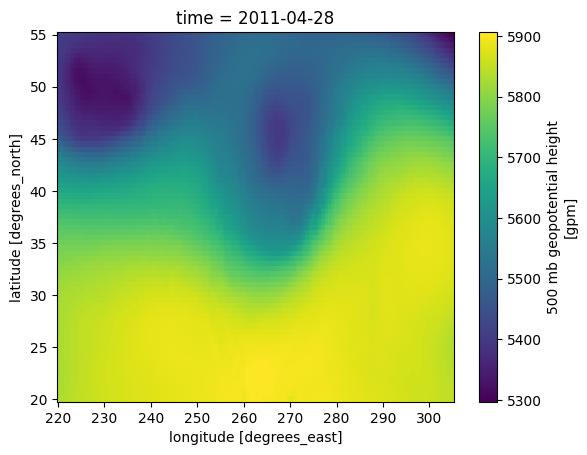

In [6]:
apr27_example_z500.plot()

We can do the same thing for any variable.

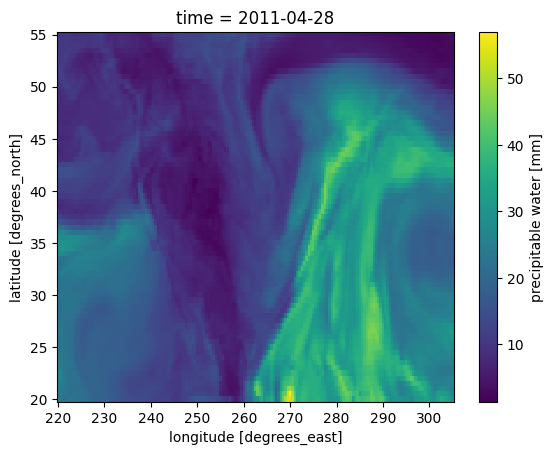

In [7]:
apr27_example['pwat'].plot()

We can also modify the ```ensemble``` selection to see how each ensemble member is different:

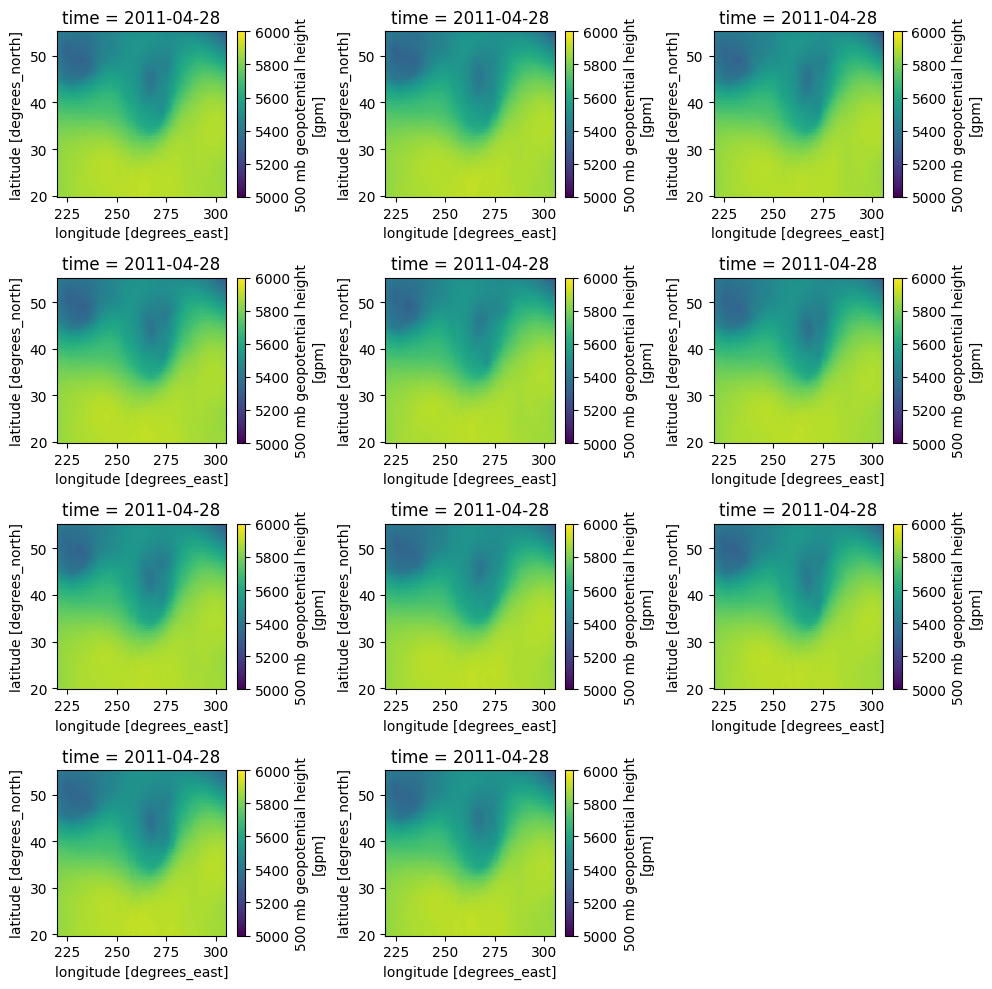

In [8]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10,10

for i in range(0, 11):

    ax = plt.subplot(4,3,i+1)
    
    apr27_example_ens = apr27.sel(time='2011-04-28 00:00:00', ens=i)
    
    apr27_example_ens['z500'].plot(ax=ax, vmin=5000, vmax=6000)
    
plt.tight_layout()   

## Preprocessed netCDF file

I have provided a preprocessed 500 hPa height file that can be used to train a SOM. These are analysis data (first time step) from the first ens member (control).

These data look generally like the examples above.

In [9]:
example_data = xr.open_dataset("/home/scratch/ahaberlie1/som_example/hpa500_test.nc")

example_data

<xarray.Dataset>
Dimensions:  (time: 1043, lat: 71, lon: 171)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-05 2000-01-12 ... 2019-12-25
  * lat      (lat) float32 55.0 54.5 54.0 53.5 53.0 ... 22.0 21.5 21.0 20.5 20.0
  * lon      (lon) float32 220.0 220.5 221.0 221.5 ... 303.5 304.0 304.5 305.0
Data variables:
    z500     (time, lat, lon) float32 ...
Attributes:
    title:         Customized GEFSv12 Reforecasts
    grid:          0.5 degree CONUS subset
    author:        Dr. Victor Gensini
    author_email:  vgensini@niu.edu